# Crypto Currency Time Series Project

This notebook aims to deliver a tuned Prophet model capable of predicting price values of some of the most famous  
crypto currencies based on the past data

In [43]:
import requests
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric

# Define API Params

First define the coin to predict, actual date and a past date of n years in the past.   
Lastly define other API params such as currency and number of decimals.

In [44]:
coin = 'ethereum'

In [45]:
url = f'https://api.coingecko.com/api/v3/coins/{coin}/market_chart/range'

In [46]:
years = 3

In [47]:
today = int(datetime.datetime.now().timestamp())

In [48]:
past_date = int((datetime.datetime.now() - datetime.timedelta(days=365 * years)).timestamp())

In [49]:
params = {'vs_currency': 'usd',
          'from': past_date,
          'to': today,
          'precision': 2}

In [50]:
response = requests.get(url, params=params).json()

In [51]:
df = pd.DataFrame(response["prices"], columns=["Timestamp", "Price"])
df.head()

,Timestamp,Price
0,1606521600000,517.55
1,1606608000000,537.39
2,1606694400000,574.75
3,1606780800000,612.26
4,1606867200000,589.58


# Data Cleaning 

Change the date table to a more human readable format, from Timestamp to yyyy-mm-dd

In [52]:
df['Date']= df['Timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime("%Y-%m-%d"))

In [53]:
df['Timestamp'] = df['Date']

In [54]:
df.drop(columns=['Date'], inplace=True)

In [55]:
df.rename(columns={'Timestamp': 'Date'}, inplace=True)

In [56]:
df['Date']=pd.to_datetime(df['Date'])

In [57]:
df.head()

,Date,Price
0,2020-11-27,517.55
1,2020-11-28,537.39
2,2020-11-29,574.75
3,2020-11-30,612.26
4,2020-12-01,589.58


In [58]:
df.dtypes

Date     datetime64[ns]
Price           float64
dtype: object

<AxesSubplot:title={'center':'ethereum trend'}, xlabel='Date', ylabel='Price'>

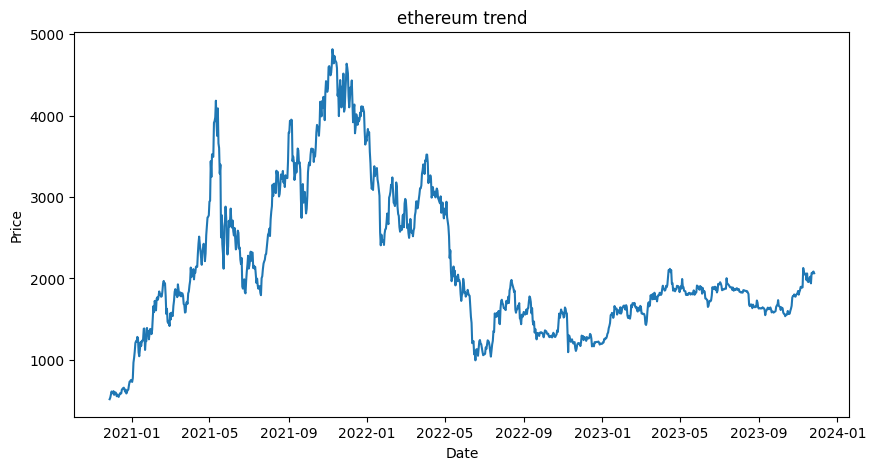

In [59]:
plt.figure(figsize=(10,5))
plt.title(f'{coin} trend')
sns.lineplot(data=df, x='Date', y='Price')

# Prophet Model

## Preparing data for Prophet

In [60]:
df.dtypes

Date     datetime64[ns]
Price           float64
dtype: object

In [61]:
df.rename(columns={'Date': 'ds',
                  'Price': 'y'}, inplace=True)

In [62]:
df.head()

,ds,y
0,2020-11-27,517.55
1,2020-11-28,537.39
2,2020-11-29,574.75
3,2020-11-30,612.26
4,2020-12-01,589.58


## Train Test Split

In [63]:
train_index = int(0.9*len(df))
train_index

985

In [64]:
train = df.iloc[:train_index]
test = df.iloc[train_index:]

In [65]:
train.tail()

,ds,y
980,2023-08-04,1828.46
981,2023-08-05,1835.07
982,2023-08-06,1826.71
983,2023-08-07,1826.93
984,2023-08-08,1856.84


In [66]:
test.head()

,ds,y
985,2023-08-09,1855.89
986,2023-08-10,1850.88
987,2023-08-11,1847.54
988,2023-08-12,1848.51
989,2023-08-13,1839.51


## Instantiate Model & Forecast (for test set)

First we will instantiate the prophet model and fit it to our train data.  
After that we will predict just the same dates of our test set and compare them.

In [67]:
model = Prophet()

In [68]:
model.fit(train)

19:15:47 - cmdstanpy - INFO - Chain [1] start processing
19:15:47 - cmdstanpy - INFO - Chain [1] done processing


In [69]:
future_test = model.make_future_dataframe(periods=len(test))

In [70]:
future_test


,ds
0,2020-11-27
1,2020-11-28
2,2020-11-29
3,2020-11-30
4,2020-12-01
...,...
1090,2023-11-22
1091,2023-11-23
1092,2023-11-24
1093,2023-11-25


In [71]:
forecast_test = model.predict(future_test)
forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1090,2023-11-22,3661.690245,3192.909890,4093.740912
1091,2023-11-23,3650.487419,3209.790773,4083.327916
1092,2023-11-24,3638.188809,3193.584121,4082.383344
1093,2023-11-25,3639.299216,3206.727195,4097.565958
1094,2023-11-26,3642.299097,3203.859478,4064.632066


In [72]:
forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].shape

(1095, 4)

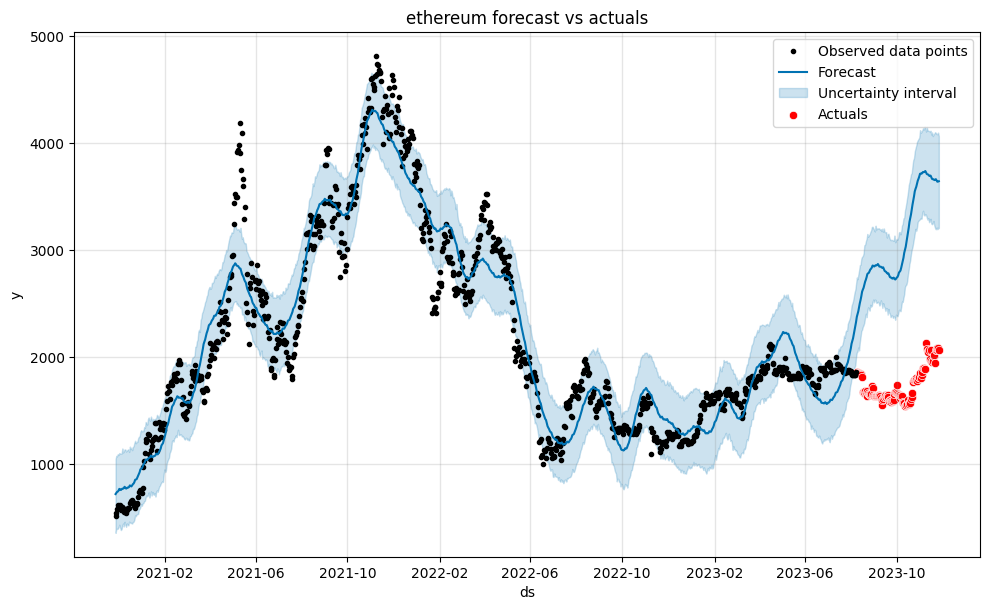

In [73]:
fig_1 = model.plot(forecast_test)

ax = plt.gca()
sns.scatterplot(x='ds', y='y', data=test, color='red', label='Actuals', ax=ax)

plt.legend()
plt.title(f'{coin} forecast vs actuals')

plt.show()

## Model Evaluation

### Simple Evaluation with Sklearn MAPE

In [74]:
predictions_test = forecast_test['yhat'].iloc[train_index:]

In [75]:
mape= mean_absolute_percentage_error(test['y'], predictions_test)
mape

0.7766178445894264

### Cross Validation Evaluation

In [76]:
#cv_results = cross_validation(model, initial='730 days', period = '30 days', horizon='365 days')

ValueError: Less data than horizon after initial window. Make horizon or initial shorter.

In [ ]:
#cv_results.head()

In [ ]:
#len(cv_results['cutoff'].unique())

In [ ]:
#df_performance = performance_metrics(cv_results)
#df_performance.head()

In [ ]:
#fig_2 = plot_cross_validation_metric(cv_results, metric='mape')
#plt.show()

# Forecasting more into the future

In [81]:
future = model.make_future_dataframe(periods=365+len(test))
future

,ds
0,2020-11-27
1,2020-11-28
2,2020-11-29
3,2020-11-30
4,2020-12-01
...,...
1455,2024-11-21
1456,2024-11-22
1457,2024-11-23
1458,2024-11-24


In [83]:
forecast_new = model.predict(future)
forecast_new[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-11-27,718.319809,383.751693,1076.025692
1,2020-11-28,727.735191,388.873035,1070.216597
2,2020-11-29,738.557764,418.627557,1084.275795
3,2020-11-30,741.828990,371.882357,1093.440224
4,2020-12-01,750.962809,410.054630,1096.342307
...,...,...,...,...
1455,2024-11-21,5919.829059,3749.008880,8176.381507
1456,2024-11-22,5906.955016,3696.575484,8213.351173
1457,2024-11-23,5907.622087,3640.811422,8225.278951
1458,2024-11-24,5910.328770,3650.741483,8233.894428


In [87]:
forecast_new.iloc[len(train)+len(test):]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1095,2023-11-27,3234.351270,3186.253543,4079.614823,2995.721458,3457.585249,403.859319,403.859319,403.859319,-2.928419,-2.928419,-2.928419,406.787738,406.787738,406.787738,0.0,0.0,0.0,3638.210589
1096,2023-11-28,3240.555772,3221.580264,4086.711013,2996.978255,3467.791921,399.853052,399.853052,399.853052,0.668377,0.668377,0.668377,399.184675,399.184675,399.184675,0.0,0.0,0.0,3640.408824
1097,2023-11-29,3246.760275,3197.619931,4079.936128,2996.953710,3478.073880,403.039486,403.039486,403.039486,11.629846,11.629846,11.629846,391.409640,391.409640,391.409640,0.0,0.0,0.0,3649.799761
1098,2023-11-30,3252.964777,3195.938421,4077.016926,2997.168446,3489.295162,386.222317,386.222317,386.222317,2.879977,2.879977,2.879977,383.342340,383.342340,383.342340,0.0,0.0,0.0,3639.187094
1099,2023-12-01,3259.169279,3210.793970,4060.792658,3000.393638,3500.252798,367.461928,367.461928,367.461928,-7.414236,-7.414236,-7.414236,374.876164,374.876164,374.876164,0.0,0.0,0.0,3626.631208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2024-11-21,5467.972091,3749.008880,8176.381507,3266.810407,7728.215148,451.856968,451.856968,451.856968,2.879977,2.879977,2.879977,448.976992,448.976992,448.976992,0.0,0.0,0.0,5919.829059
1456,2024-11-22,5474.176593,3696.575484,8213.351173,3265.496328,7740.783782,432.778423,432.778423,432.778423,-7.414236,-7.414236,-7.414236,440.192659,440.192659,440.192659,0.0,0.0,0.0,5906.955016
1457,2024-11-23,5480.381095,3640.811422,8225.278951,3264.592694,7756.977288,427.240992,427.240992,427.240992,-4.640086,-4.640086,-4.640086,431.881078,431.881078,431.881078,0.0,0.0,0.0,5907.622087
1458,2024-11-24,5486.585597,3650.741483,8233.894428,3263.689059,7776.593804,423.743172,423.743172,423.743172,-0.195459,-0.195459,-0.195459,423.938631,423.938631,423.938631,0.0,0.0,0.0,5910.328770


In [86]:
test

,ds,y
985,2023-08-09,1855.89
986,2023-08-10,1850.88
987,2023-08-11,1847.54
988,2023-08-12,1848.51
989,2023-08-13,1839.51
...,...,...
1090,2023-11-22,2065.94
1091,2023-11-23,2062.27
1092,2023-11-24,2080.85
1093,2023-11-25,2085.43


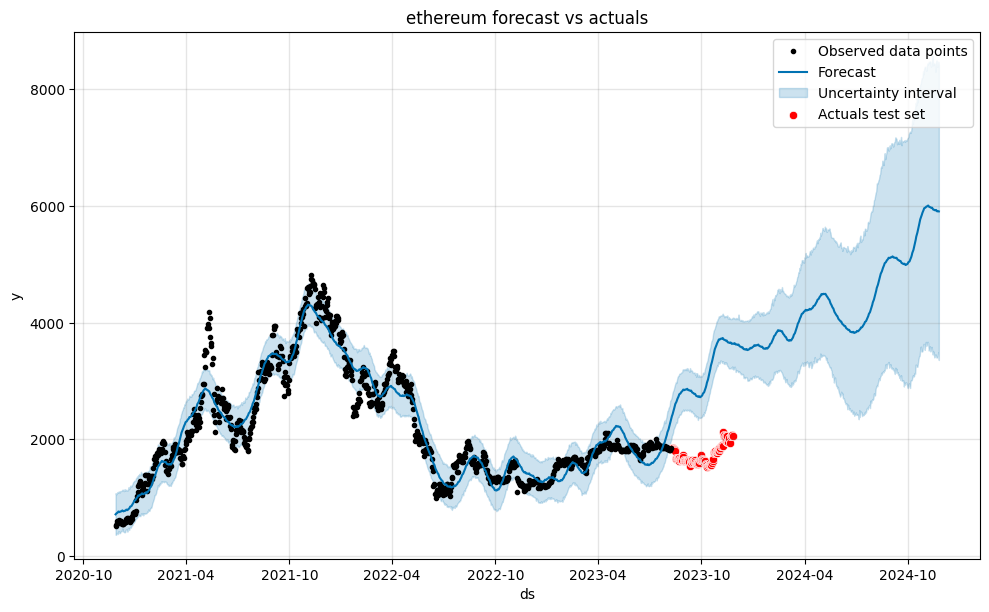

In [79]:
fig_3 = model.plot(forecast_new)

ax = plt.gca()
sns.scatterplot(x='ds', y='y', data=test, color='red', label='Actuals test set', ax=ax)

plt.legend()
plt.title(f'{coin} forecast vs actuals')

plt.show()